In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" #type:ignore
plt.style.use('dark_background') # dark_background "default
sns.set_context('paper')

%reload_ext autoreload
%autoreload 2

from paper01_conf import *

# Load hashes

In [90]:
from phaser.utils import load_labelencoders, bin2bool

# Load the label encoders
le = load_labelencoders(filename="LabelEncoders", path="./demo_outputs/")

TRANSFORMS = le['t'].classes_
METRICS    = le['m'].classes_
ALGORITHMS = le['a'].classes_

df_h = pd.read_csv("./demo_outputs/hashes.csv")

# Get the count of each transform. Should be 250k each.
df_h.groupby(['transformation']).count()

,filename,phash,wave,pdq
transformation,,,,
0,999995,999995,999995,999995
1,999995,999995,999995,999995
2,999995,999995,999995,999995
3,999995,999995,999995,999995
4,999995,999995,999995,999995
5,999995,999995,999995,999995
6,999995,999995,999995,999995


In [138]:
# Convert binary to boolean for distance computation
for a in le["a"].classes_:
    df_h[a] = df_h[a].apply(bin2bool)

## Remove 'wave' hashes that sum to 1

In [139]:
# nasty hack to find hashes with all bits set to False
mask = df_h['wave'].apply(lambda x: sum(x)) == 0
bad_filenames = df_h[mask]['filename'].unique()
print(f"Found {len(bad_filenames)} bad filenames. Removing from main hashes")

Found 9 bad filenames. Removing from main hashes


In [140]:
df_h = df_h[~df_h['filename'].isin(bad_filenames)]

## Subset to 250k samples

In [141]:
subset_size = 250000

unique_files = sorted(df_h['filename'].unique())
sampled_files = np.random.choice(unique_files, subset_size, replace=False)

df_h_sub = df_h[df_h['filename'].isin(sampled_files)]
df_h_sub.groupby(['transformation']).count()

,filename,phash,wave,pdq
transformation,,,,
0,250000,250000,250000,250000
1,250000,250000,250000,250000
2,250000,250000,250000,250000
3,250000,250000,250000,250000
4,250000,250000,250000,250000
5,250000,250000,250000,250000
6,250000,250000,250000,250000


# Compute distances

In [144]:
print(f"Computing distances using the following metrics")
M_DICT.keys()

Computing distances using the following metrics


dict_keys(['Hamming', 'Cosine'])

In [145]:
from phaser.similarities import IntraDistance, InterDistance, find_inter_samplesize

c:\Users\aabywan\anaconda3\envs\my_lib\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [168]:
INTRA = IntraDistance(M_DICT, le, set_class=1, progress_bar=True)
dist_intra = INTRA.fit(df_h_sub)

Hash: 100%|██████████| 3/3 [02:50<00:00, 56.87s/it]


In [195]:
dist_intra.head()

,fileA,fileB,algo,metric,class,Border_bw30_bc255.255.255,"Crop_fixed[0.05, 0.05, 0.05, 0.05]",Flip_Horizontal,"Rescale_fixed(96, 96)",Rotate_5,Watermark,orig
0,1,1,0,0,1,0.789062,0.945312,0.507812,0.875000,0.671875,0.882812,1
1,3,3,0,0,1,0.867187,0.976562,0.500000,0.929687,0.679687,0.953125,1
2,8,8,0,0,1,0.812500,0.960937,0.492187,0.890625,0.671875,0.953125,1
3,13,13,0,0,1,0.757812,0.968750,0.507812,0.968750,0.632812,0.914062,1
4,17,17,0,0,1,0.906250,0.992187,0.484375,0.929687,0.742187,0.953125,1


In [178]:
dist_intra.groupby(['algo','metric']).count()

fileA   fileB   class  Border_bw30_bc255.255.255  \
algo metric                                                      
0    0       250000  250000  250000                     250000   
     1       250000  250000  250000                     250000   
1    0       250000  250000  250000                     250000   
     1       250000  250000  250000                     250000   
2    0       250000  250000  250000                     250000   
     1       250000  250000  250000                     250000   

             Crop_fixed[0.05, 0.05, 0.05, 0.05]  Flip_Horizontal  \
algo metric                                                        
0    0                                   250000           250000   
     1                                   250000           250000   
1    0                                   250000           250000   
     1                                   250000           250000   
2    0                                   250000           250000   
     1                                   250000           250000   

             Rescale_fixed(96, 96)  Rotate_5  Watermark    orig  
algo metric                                                      
0    0                      250000    250000     250000  250000  
     1                      250000    250000     250000  250000  
1    0                      250000    250000     250000  250000  
     1                      250000    250000     250000  250000  
2    0                      250000    250000     250000  250000  
     1                      250000    250000     250000  250000

In [192]:
n_samples = find_inter_samplesize(len(df_h_sub["filename"].unique() * 1))
print(n_samples)

INTER = InterDistance(M_DICT, le, set_class=0, n_samples=n_samples, progress_bar=True)
dist_inter = INTER.fit(df_h_sub)

708


Hash: 100%|██████████| 3/3 [00:00<00:00,  5.07it/s]


In [196]:
dist_inter.head()

,fileA,fileB,algo,metric,class,Border_bw30_bc255.255.255,"Crop_fixed[0.05, 0.05, 0.05, 0.05]",Flip_Horizontal,"Rescale_fixed(96, 96)",Rotate_5,Watermark,orig
0,417,2859,0,0,0,0.539062,0.500000,0.476562,0.500000,0.468750,0.492187,0.476562
1,417,3232,0,0,0,0.515625,0.468750,0.484375,0.468750,0.484375,0.468750,0.460937
2,417,4702,0,0,0,0.593750,0.523437,0.500000,0.523437,0.554687,0.531250,0.507812
3,417,4709,0,0,0,0.546875,0.539062,0.531250,0.562500,0.562500,0.531250,0.539062
4,417,4750,0,0,0,0.585937,0.515625,0.492187,0.507812,0.609375,0.492187,0.523437


In [198]:
dist_inter.groupby(['algo','metric']).count()

fileA   fileB   class  Border_bw30_bc255.255.255  \
algo metric                                                      
0    0       250278  250278  250278                     250278   
     1       250278  250278  250278                     250278   
1    0       250278  250278  250278                     250278   
     1       250278  250278  250278                     250278   
2    0       250278  250278  250278                     250278   
     1       250278  250278  250278                     250278   

             Crop_fixed[0.05, 0.05, 0.05, 0.05]  Flip_Horizontal  \
algo metric                                                        
0    0                                   250278           250278   
     1                                   250278           250278   
1    0                                   250278           250278   
     1                                   250278           250278   
2    0                                   250278           250278   
     1                                   250278           250278   

             Rescale_fixed(96, 96)  Rotate_5  Watermark    orig  
algo metric                                                      
0    0                      250278    250278     250278  250278  
     1                      250278    250278     250278  250278  
1    0                      250278    250278     250278  250278  
     1                      250278    250278     250278  250278  
2    0                      250278    250278     250278  250278  
     1                      250278    250278     250278  250278

In [170]:
len(dist_intra['fileA'].unique())
len(dist_inter['fileA'].unique())

250000

707

In [199]:
df_d = pd.concat([dist_intra,dist_inter])

## Compute metrics

In [200]:
# Define the triplet combinations
triplets = np.array(np.meshgrid(
    ALGORITHMS, 
    [t for t in TRANSFORMS if t != 'orig'], # ignore 'orig'
    METRICS)).T.reshape(-1,3)

print(f"Number of triplets to analyse: {len(triplets)}")

Number of triplets to analyse: 36


In [209]:
from phaser.evaluation import ComputeMetrics

cm = ComputeMetrics(le, df_d, df_h_sub, analyse_bits=True, n_jobs=1)
m, b = cm.fit(triplets, weighted=False)

Triplet: 100%|██████████| 36/36 [01:21<00:00,  2.27s/it]


In [210]:
m

,Algorithm,Transform,Metric,AUC,EER,Threshold,TN,FP,FN,TP
0,pdq,Border_bw30_bc255.255.255,Cosine,0.999654,0.003985,0.640067,249328.0,950.0,1013.0,248987.0
1,pdq,"Crop_fixed[0.05, 0.05, 0.05, 0.05]",Cosine,1.000000,0.000024,0.638665,250274.0,4.0,6.0,249994.0
2,pdq,Flip_Horizontal,Cosine,0.516549,0.494668,0.504368,137430.0,112848.0,146111.0,103889.0
3,pdq,"Rescale_fixed(96, 96)",Cosine,0.999972,0.000214,0.617540,250257.0,21.0,62.0,249938.0
4,pdq,Rotate_5,Cosine,0.990327,0.039587,0.587300,243713.0,6565.0,12102.0,237898.0
5,pdq,Watermark,Cosine,0.999981,0.000384,0.624026,250189.0,89.0,97.0,249903.0
6,phash,Border_bw30_bc255.255.255,Cosine,0.940950,0.131340,0.694475,233209.0,17069.0,51671.0,198329.0
7,phash,"Crop_fixed[0.05, 0.05, 0.05, 0.05]",Cosine,0.999975,0.000308,0.748076,250219.0,59.0,78.0,249922.0
8,phash,Flip_Horizontal,Cosine,0.494088,0.512329,0.523585,133776.0,116502.0,153639.0,96361.0
9,phash,"Rescale_fixed(96, 96)",Cosine,0.999996,0.000183,0.760072,250266.0,12.0,56.0,249944.0


In [211]:
m.groupby(['Algorithm'])[['AUC','EER']].agg(['mean','std'])
m.groupby(['Algorithm','Transform'])[['AUC','EER']].agg(['mean','std'])

AUC                 EER          
               mean       std      mean       std
Algorithm                                        
pdq        0.917747  0.187435  0.089810  0.189681
phash      0.905220  0.193319  0.111962  0.193121
wave       0.817014  0.319204  0.188056  0.295497

AUC                \
                                                  mean           std   
Algorithm Transform                                                    
pdq       Border_bw30_bc255.255.255           0.999654  0.000000e+00   
          Crop_fixed[0.05, 0.05, 0.05, 0.05]  1.000000  0.000000e+00   
          Flip_Horizontal                     0.516549  0.000000e+00   
          Rescale_fixed(96, 96)               0.999972  0.000000e+00   
          Rotate_5                            0.990327  0.000000e+00   
          Watermark                           0.999981  0.000000e+00   
phash     Border_bw30_bc255.255.255           0.940951  1.736138e-06   
          Crop_fixed[0.05, 0.05, 0.05, 0.05]  0.999975  3.713781e-07   
          Flip_Horizontal                     0.494088  3.498777e-07   
          Rescale_fixed(96, 96)               0.999996  3.492053e-09   
          Rotate_5                            0.996528  2.080438e-06   
          Watermark                           0.999784  2.700221e-06   
wave      Border_bw30_bc255.255.255           0.167148  1.743823e-05   
          Crop_fixed[0.05, 0.05, 0.05, 0.05]  0.999965  7.810100e-06   
          Flip_Horizontal                     0.739921  5.264557e-05   
          Rescale_fixed(96, 96)               0.999968  1.039304e-05   
          Rotate_5                            0.995251  1.072604e-05   
          Watermark                           0.999831  7.045872e-06   

                                                   EER            
                                                  mean       std  
Algorithm Transform                                               
pdq       Border_bw30_bc255.255.255           0.003985  0.000000  
          Crop_fixed[0.05, 0.05, 0.05, 0.05]  0.000024  0.000000  
          Flip_Horizontal                     0.494668  0.000000  
          Rescale_fixed(96, 96)               0.000214  0.000000  
          Rotate_5                            0.039587  0.000000  
          Watermark                           0.000384  0.000000  
phash     Border_bw30_bc255.255.255           0.131339  0.000001  
          Crop_fixed[0.05, 0.05, 0.05, 0.05]  0.000308  0.000000  
          Flip_Horizontal                     0.512329  0.000000  
          Rescale_fixed(96, 96)               0.000182  0.000001  
          Rotate_5                            0.024457  0.000000  
          Watermark                           0.003159  0.000000  
wave      Border_bw30_bc255.255.255           0.763481  0.000021  
          Crop_fixed[0.05, 0.05, 0.05, 0.05]  0.000798  0.000001  
          Flip_Horizontal                     0.329641  0.000086  
          Rescale_fixed(96, 96)               0.000660  0.000005  
          Rotate_5                            0.029227  0.000004  
          Watermark                           0.004532  0.000002

# Compute distances with bit weights

In [212]:
from phaser.evaluation import make_bit_weights
bit_weights = make_bit_weights(b, le['a'].classes_, le['m'].classes_, le['t'].classes_)

In [213]:
INTRA_w = IntraDistance(M_DICT, le, set_class=1, bit_weights=bit_weights, progress_bar=True)
dist_intra_w = INTRA_w.fit(df_h_sub)

Hash: 100%|██████████| 3/3 [06:26<00:00, 128.89s/it]


In [214]:
INTER_w = InterDistance(M_DICT, le, set_class=0, n_samples=n_samples, bit_weights=bit_weights, progress_bar=True)
dist_inter_w = INTER_w.fit(df_h_sub)

Hash: 100%|██████████| 3/3 [03:41<00:00, 73.89s/it]


In [216]:
df_d_w = pd.concat([dist_intra_w,dist_inter_w])

In [217]:
cm_w = ComputeMetrics(le, df_d_w, df_h_sub, analyse_bits=False, n_jobs=1)
m_w, b_w = cm_w.fit(triplets, weighted=False)

Triplet: 100%|██████████| 36/36 [00:06<00:00,  5.49it/s]


# Compare performance

In [278]:
print(f"Performance without bit weights")
print(m.groupby(['Algorithm', 'Metric'])[['AUC','EER']].agg(['mean','std']).to_latex(index=False))

print(f"Performance WITH bit weights")
print(m_w.groupby(['Algorithm', 'Metric'])[['AUC','EER']].agg(['mean','std']).to_latex(index=False))

Performance without bit weights
\begin{tabular}{rrrr}
\toprule
\multicolumn{2}{r}{AUC} & \multicolumn{2}{r}{EER} \\
mean & std & mean & std \\
\midrule
0.917747 & 0.196584 & 0.089810 & 0.198939 \\
0.917747 & 0.196584 & 0.089810 & 0.198939 \\
0.905219 & 0.202754 & 0.111963 & 0.202547 \\
0.905221 & 0.202755 & 0.111962 & 0.202547 \\
0.817014 & 0.334785 & 0.188050 & 0.309919 \\
0.817014 & 0.334784 & 0.188063 & 0.309921 \\
\bottomrule
\end{tabular}

Performance WITH bit weights
\begin{tabular}{rrrr}
\toprule
\multicolumn{2}{r}{AUC} & \multicolumn{2}{r}{EER} \\
mean & std & mean & std \\
\midrule
0.968876 & 0.071771 & 0.047238 & 0.095846 \\
0.969058 & 0.071250 & 0.046653 & 0.094072 \\
0.930906 & 0.129414 & 0.089689 & 0.142516 \\
0.931856 & 0.127735 & 0.088441 & 0.139666 \\
0.819962 & 0.328628 & 0.184997 & 0.306028 \\
0.819821 & 0.329536 & 0.185202 & 0.306594 \\
\bottomrule
\end{tabular}



c:\Users\aabywan\anaconda3\envs\my_lib\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\aabywan\anaconda3\envs\my_lib\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\aabywan\anaconda3\envs\my_lib\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\aabywan\anaconda3\envs\my_lib\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(d

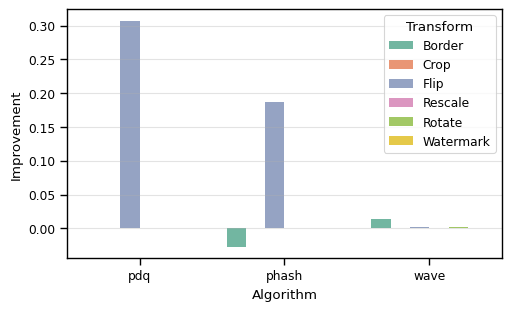

In [323]:
cols = ['Algorithm', 'Transform', 'Metric', 'AUC_noW', 'AUC_wW']
_df = pd.DataFrame(np.column_stack([
    m['Algorithm'], 
    m['Transform'], 
    m['Metric'],
    m['AUC'],
    m_w['AUC']]), columns=cols)

_df['Improvement'] = _df['AUC_wW'] - _df['AUC_noW']

plt.style.use('default') # dark_background "default
sns.set_context('paper')

fig, ax = plt.subplots(1,1, figsize=FIGSIZE, constrained_layout=True)
ax = sns.barplot(_df[_df['Metric']=='Hamming'], x='Algorithm', y='Improvement', hue='Transform', palette='Set2', ax=ax)
# Get custom SNS legend handles from KDE plot
handles = ax.legend_.legend_handles #type:ignore

for handle, txt in zip(handles, ax.legend_.texts): #type:ignore
    # assign the legend labels to the handles
    handle.set_label(txt.get_text().split("_")[0]) #type:ignore
# Update custom SNS legend with the added line.
_ = ax.legend(handles=handles , loc="upper right", title='Transform')
_ = ax.grid(axis='y', alpha=0.35)

fig.savefig("./demo_outputs/figs/AUC_weight_improvements.pdf")  

#plt.legend(labels=['Border', 'Crop', 'Flip', 'Rescale',' Rotate', 'Water'])
#plt.show()
#ax = sns.barplot(_df[_df['Metric']=='Cosine'], x='Algorithm', y='Improvement', hue='Transform', palette='Set2')
#plt.yscale('log')
#_df.groupby(['Transform'])

In [219]:
m_w

,Algorithm,Transform,Metric,AUC,EER,Threshold,TN,FP,FN,TP
0,pdq,Border_bw30_bc255.255.255,Cosine,0.999562,0.004919,0.634922,249048.0,1230.0,1230.0,248770.0
1,pdq,"Crop_fixed[0.05, 0.05, 0.05, 0.05]",Cosine,1.000000,0.000016,0.638273,250274.0,4.0,4.0,249996.0
2,pdq,Flip_Horizontal,Cosine,0.822547,0.240636,0.522666,190053.0,60225.0,60160.0,189840.0
3,pdq,"Rescale_fixed(96, 96)",Cosine,0.999983,0.000180,0.615199,250234.0,44.0,45.0,249955.0
4,pdq,Rotate_5,Cosine,0.991183,0.037300,0.583085,240943.0,9335.0,9325.0,240675.0
5,pdq,Watermark,Cosine,0.999982,0.000380,0.619346,250185.0,93.0,95.0,249905.0
6,phash,Border_bw30_bc255.255.255,Cosine,0.912107,0.159184,0.674389,210438.0,39840.0,39796.0,210204.0
7,phash,"Crop_fixed[0.05, 0.05, 0.05, 0.05]",Cosine,0.999982,0.000260,0.730289,250213.0,65.0,65.0,249935.0
8,phash,Flip_Horizontal,Cosine,0.676503,0.352013,0.531087,162177.0,88101.0,88000.0,162000.0
9,phash,"Rescale_fixed(96, 96)",Cosine,0.999998,0.000164,0.747258,250236.0,42.0,41.0,249959.0


# Visualising bit weights 

In [279]:
from phaser.plotting import bit_weights_ax

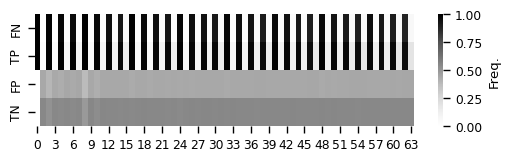

In [321]:
fig, ax = plt.subplots(1,1, figsize=(5,1.5), constrained_layout=True)
_ = bit_weights_ax(b["phash_Flip_Horizontal_Hamming"], ax=ax)
fig.savefig("./demo_outputs/figs/bit_w_phash_Flip_Horizontal_Hamming.pdf")

In [282]:
[k for k in bit_weights.keys()]

['pdq_Cosine',
 'pdq_Hamming',
 'phash_Cosine',
 'phash_Hamming',
 'wave_Cosine',
 'wave_Hamming']

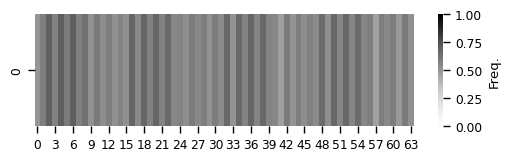

In [322]:
fig, ax = plt.subplots(1,1, figsize=(5,1.5), constrained_layout=True)
_ = bit_weights_ax(pd.DataFrame(bit_weights['phash_Hamming']), ax=ax)
fig.savefig("./demo_outputs/figs/bit_w_phash_median.pdf")

In [291]:
[k for k in b.keys()]

['pdq_Border_bw30_bc255.255.255_Cosine',
 'pdq_Crop_fixed[0.05, 0.05, 0.05, 0.05]_Cosine',
 'pdq_Flip_Horizontal_Cosine',
 'pdq_Rescale_fixed(96, 96)_Cosine',
 'pdq_Rotate_5_Cosine',
 'pdq_Watermark_Cosine',
 'phash_Border_bw30_bc255.255.255_Cosine',
 'phash_Crop_fixed[0.05, 0.05, 0.05, 0.05]_Cosine',
 'phash_Flip_Horizontal_Cosine',
 'phash_Rescale_fixed(96, 96)_Cosine',
 'phash_Rotate_5_Cosine',
 'phash_Watermark_Cosine',
 'wave_Border_bw30_bc255.255.255_Cosine',
 'wave_Crop_fixed[0.05, 0.05, 0.05, 0.05]_Cosine',
 'wave_Flip_Horizontal_Cosine',
 'wave_Rescale_fixed(96, 96)_Cosine',
 'wave_Rotate_5_Cosine',
 'wave_Watermark_Cosine',
 'pdq_Border_bw30_bc255.255.255_Hamming',
 'pdq_Crop_fixed[0.05, 0.05, 0.05, 0.05]_Hamming',
 'pdq_Flip_Horizontal_Hamming',
 'pdq_Rescale_fixed(96, 96)_Hamming',
 'pdq_Rotate_5_Hamming',
 'pdq_Watermark_Hamming',
 'phash_Border_bw30_bc255.255.255_Hamming',
 'phash_Crop_fixed[0.05, 0.05, 0.05, 0.05]_Hamming',
 'phash_Flip_Horizontal_Hamming',
 'phash_Resca

In [ ]:
# Select a triplet to analyse!
idx = 13
a_s, t_s, m_s = triplets[idx]
trip_name = "_".join(triplets[idx])

print(f"Analysing:\n\tA='{a_s}'\n\tT='{t_s}'\n\tM='{m_s}'")

# from string to integer label encoding
a_l = le['a'].transform(np.array(a_s).ravel())[0]
t_l = le['t'].transform(np.array(t_s).ravel())[0]
m_l = le['m'].transform(np.array(m_s).ravel())[0]

print(f"Corresponding labels:\n\t{a_l=}\n\t{t_l=}\n\t{m_l=}")

# subset the triplet data
subset = df_d[(df_d['algo'] == a_l) & (df_d['metric'] == m_l)].copy()

y_true = subset['class']
y_sims = subset[t_s].values

In [ ]:
i = np.argwhere(np.isnan(y_sims))
print(i)
subset.loc[subset.index[i[0]]]

In [ ]:
from phaser.utils import ImageLoader as IL
from phaser.hashing import WaveHash
from phaser.transformers import Border, Flip
print(IMGPATH)

fileA = subset.loc[subset.index[i[0]]]['fileA']
fileA = 377332
img_name = le['f'].inverse_transform(np.array([fileA]).reshape(-1))[0]
path = pathlib.Path(IMGPATH).joinpath(img_name)
print(path)
img_obj = IL(path=str(path))
print(f"Wave hash of nasty img = '{WaveHash().fit(img_obj.image)}'")

border_img = Border(border_colour=(255,255,255), border_width=30).fit(img_obj)
print(f"Wave hash of nasty img = '{WaveHash().fit(border_img)}'")

border_img = Flip().fit(img_obj)
print(f"Wave hash of nasty img = '{WaveHash().fit(border_img)}'")

In [ ]:
_filter = df_h['wave'].apply(lambda x: sum(x)) == 0

In [ ]:
bad_filenames = df_h[_filter]['filename'].unique()

In [ ]:
df_h[~df_h['filename'].isin(bad_filenames)]

In [ ]:

len(y_sims)

y_sims[i]

In [ ]:
np.isnan(y_sims).any()

In [ ]:
plt.plot(sorted(y_sims.values))

In [ ]:
# Compute metrics
fpr, tpr, thresholds = roc_curve(y_true=y_true, y_score=y_sims)

plt.hist(y_sims)

In [ ]:


mm = MetricMaker(y_true, y_sims, weighted=False)
cm = mm.get_cm(threshold=mm.eer_thresh, normalize='none', breakdown=False)
tn, fp, fn, tp = cm.ravel() # type:ignore

y_pred = mm.y_pred
print(f"AUC={mm.auc*100:.2f}%")

# Bit analysis
# Select the CM quadrants to analyze bits individually
FN = subset[(subset["class"] == 1) & (subset["class"] != y_pred)]
TP = subset[(subset["class"] == 1) & (subset["class"] == y_pred)]
FP = subset[(subset["class"] == 0) & (subset["class"] != y_pred)]
TN = subset[(subset["class"] == 0) & (subset["class"] == y_pred)]

o_l = np.where(le['t'].classes_ == "orig")[0][0]

In [ ]:
from phaser.evaluation import BitAnalyzer
BA = BitAnalyzer(df_h, le['t'])
bitfreq = BA.fit(subset, y_pred, t_l, a_s)

from phaser.plotting import bit_weights_ax
fig, ax = plt.subplots(1,1,figsize=(15,2))
ax = bit_weights_ax(bits=bitfreq, title=trip_name, ax=ax)

In [ ]:
# compute all distances using the new bitweights!
intra = IntraDistance(M_DICT, le, 1,
    bit_weights=bit_weights, # weighted distances!!!
    progress_bar=True)
intra_df = intra.fit(df_h)

from phaser.similarities import find_inter_samplesize
# Compute the inter distances using subsampling
n_samples = find_inter_samplesize(len(df_h["filename"].unique() * 1))

inter = InterDistance(M_DICT, le, 0,
    bit_weights=bit_weights, # weighted distances!!!
    n_samples=n_samples,
    progress_bar=True)
inter_df = inter.fit(df_h)

In [ ]:
df_d_w = pd.concat([intra_df, inter_df])

# recompute metrics with weighted distances. No need to analyse bits again !?
cm = ComputeMetrics(le, df_d_w, df_h, analyse_bits=False, n_jobs=-1, progress_bar=True)
metrics_w, _ = cm.fit(triplets=triplets, weighted=False)

print(f"Performance when applying bit weights:")
print(f"Overall AUC={metrics_w['AUC'].mean():.2f} (±{metrics_w['AUC'].std():.2f})")
print(f"Overall EER={metrics_w['EER'].mean():.2f} (±{metrics_w['EER'].std():.2f})")
metrics_w

In [ ]:
# Do a quick plot 
import seaborn as sns

for dist_metric in M_DICT.keys():
    fig, ax = plt.subplots(1,2,figsize=(8,3), constrained_layout=True, sharex=True, sharey=True)
    _ = sns.barplot(
        data=metrics[metrics['Metric'] == dist_metric], #type:ignore
        x='Algorithm', 
        y='AUC', 
        hue='Transform',
        ax=ax[0])

    _ = sns.barplot(
        data=metrics_w[metrics_w['Metric'] == dist_metric], #type:ignore
        x='Algorithm', 
        y='AUC', 
        hue='Transform',
        ax=ax[1])

    #_ = ax.grid(axis='y', alpha=.25)
    _ = ax[0].legend(loc='lower right')
    _ = ax[1].legend(loc='lower right')
    _ = ax[0].set(title=f"'{dist_metric}' $without$ bit-weighting")
    _ = ax[1].set(title=f"'{dist_metric}' $with$ bit-weighting")
    fig.savefig("./demo_outputs/figs/perf_comparison.png")
    plt.close()

Decide which triplet combination to analyse

In [ ]:
print(f"Algorithms available\n{np.column_stack([np.arange(0,len(ALGORITHMS),1), ALGORITHMS])}\n")
print(f"Transformations available\n{np.column_stack([np.arange(0,len(TRANSFORMS),1), TRANSFORMS])}\n")
print(f"Metrics available\n{np.column_stack([np.arange(0,len(METRICS),1), METRICS])}\n")

In [ ]:
# Create a label encoder for the class labels
le_c = LabelEncoder()
le_c.classes_ = np.array(['Inter (0)','Intra (1)'])

all_the_bits = {}
evaluation_results = []

triplets = np.array(np.meshgrid(
    ALGORITHMS, 
    TRANSFORMS[:-1], 
    METRICS)).T.reshape(-1,3)

print(f"Number of triplets to analyse: {len(triplets)}")

In [ ]:
#from phaser.evaluation import BitAnalyzer
BA = BitAnalyzer(df_h, le_t)

metrics = []
bitfreq = {}

for triplet in triplets:
    a_s, t_s, m_s = triplet

    # from string to integer label encoding
    a_l = le_a.transform(np.array(a_s).ravel())[0]
    t_l = le_t.transform(np.array(t_s).ravel())[0]
    m_l = le_m.transform(np.array(m_s).ravel())[0]

    # subset the triplet data
    subset = df_d[
        (df_d['algo'] == a_l) & 
        (df_d['metric'] == m_l)].copy()
    
    y_true = subset['class']
    y_sims = subset[t_s]

    mm = MetricMaker(y_true, y_sims, weighted=False)
    tn, fp, fn, tp = mm.get_cm(
        threshold=mm.eer_thresh, 
        normalize='none', 
        breakdown=True)

    _m = [a_s,t_s,m_s,mm.auc,mm.eer_score,mm.eer_thresh,tn, fp, fn, tp]
    _b = BA.fit(subset, mm.y_pred, t_l, a_s)

    metrics.append(_m)
    bitfreq[f"{a_s}_{t_s}_{m_s}"] = _b
    #bitfreq.append(_b)

metrics = np.row_stack(metrics)

cols = ['Algorithm', 'Transform', 'Metric', 'AUC', 'EER', 'Threshold', 'TN','FP','FN','TP']
metrics = pd.DataFrame(metrics, columns=cols)
metrics[metrics.columns[3:]] = metrics[metrics.columns[3:]].astype(float)

In [ ]:
from phaser.evaluation import ComputeMetrics
cm = ComputeMetrics(le_f, le_a, le_t, le_m, df_d, df_h, analyse_bits=True, n_jobs=-1, progress_bar=True)
metrics, bitfreq = cm.fit(triplets=triplets, weighted=False)

In [ ]:
#results.replace([np.inf, -np.inf], 0, inplace=True)
dist_metric='Hamming'
fig, ax = plt.subplots(1,1,figsize=FIGSIZE, constrained_layout=True)
_ = sns.barplot(
    data=metrics[metrics['Metric'] == dist_metric], #type:ignore
    x='Algorithm', 
    y='AUC', 
    hue='Transform',
    ax=ax)
_ = ax.grid(axis='y', alpha=.25)
_ = ax.legend(loc='lower right')
_ = ax.set(
    title=f"Performance for '{dist_metric}' distance $without$ bit-weighting",
    yticks=np.arange(0,1.01,0.1))


In [ ]:
fig, ax = plt.subplots(1,1,figsize=FIGSIZE, constrained_layout=True)
_ = sns.heatmap(bitfreq['colour_Border_bw20_bc255.0.0_Cosine'].T, cmap='Greys', ax=ax)

# Bit-wise analysis

1. Intra-image bits should remain the same
2. Inter-image bits should change

In both cases, the positive outcome is defined as the ```True``` case.

```TP``` = Intra (1) correctly classified as Intra (1)   
```FP``` = Inter (0) falsely classified as Intra (1)   
```TN``` = Inter (0) correctly classfied as Inter (0)     
```FN``` = Intra (1) falsely classified as Inter (0)

# All the bits
Aggregate weights accross different transforms since it is unreal to expect knowing which modifications may have happened to a target image.

Thus, we want weights to work holisticly

In [ ]:
mean_weights = {}

for a in ALGORITHMS:
    #if a == 'phash':
        for m in METRICS:
            #if m == 'Hamming':
                pair = f"{a}_{m}"
                _weights = []

                for t in TRANSFORMS:
                    if t == 'orig' : continue
                    bits = bitfreq[f"{a}_{t}_{m}"]
                    means = bits.T.mean().values 
                    _weights.append(means)
                mean_weights[pair] = np.mean(_weights, axis=0)

Apply bit-weighting

In [ ]:
from scipy.spatial.distance import hamming
from scipy.spatial.distance import cdist
from tqdm import tqdm

In [ ]:
class IntraDistance:
    def __init__(
        self, 
        le_t, 
        le_m, 
        le_a, 
        dist_w=None, # would expect a dicitonary
        distance_metrics={}, 
        set_class=0, 
        progress_bar=False):
        # 
        self.le_t = le_t
        self.le_m = le_m
        self.le_a = le_a
        self.dist_w = dist_w
        self.distance_metrics = distance_metrics
        self.set_class = set_class
        self.progress_bar = progress_bar

        #validate_metrics(self.distance_metrics)

    def intradistance(self, x, algorithm, metric, weights):
        # store the first hash and reshape into 2d array as required by cdist func.
        xa = x[algorithm].iloc[0].reshape(1, -1)

        # row stack the other hashes
        xb = x.iloc[1:][algorithm].values
        xb = np.row_stack(xb)

        # Get the vlaue corresponding to the metric key.
        # This is either a string representing a name from scipy.spatial.distances
        # or a callable function implementing another metric.
        metric_value = self.distance_metrics[metric]
        
        return cdist(xa, xb, metric=metric_value, w=weights)

    def fit(self, data):
        self.files_ = data["filename"].unique()
        self.n_files_ = len(self.files_)

        distances = []

        for a in tqdm(self.le_a.classes_, disable=not self.progress_bar, desc="Hash"):
            for m in self.le_m.classes_:
                
                if self.dist_w:
                    w = self.dist_w[f"{a}_{m}"]
                else: w=None
                
                # Compute the distances for each filename
                grp_dists = data.groupby(["filename"]).apply(
                    self.intradistance, 
                    algorithm=a, 
                    metric=m,
                    weights=w
                )

                # Stack each distance into rows
                grp_dists = np.row_stack(grp_dists)

                # Get the integer labels for algo and metric
                a_label = self.le_a.transform(a.ravel())[0]
                m_label = self.le_m.transform(m.ravel())

                grp_dists = np.column_stack(
                    [
                        self.files_,  # fileA
                        self.files_,  # fileB (same in intra!)
                        np.repeat(a_label, self.n_files_),
                        np.repeat(m_label, self.n_files_),
                        np.repeat(self.set_class, self.n_files_),
                        grp_dists,
                    ]
                )
                distances.append(grp_dists)

        distances = np.concatenate(distances)

        # Create the dataframe output
        cols = ["fileA", "fileB", "algo", "metric", "class", *self.le_t.classes_[:-1]]
        distances = pd.DataFrame(distances, columns=cols)
        distances["orig"] = 0

        # set int columns accordingly
        int_cols = cols[:5]
        distances[int_cols] = distances[int_cols].astype(int)

        # Convert distances to similarities
        sim_cols = distances.columns[5:]
        distances[sim_cols] = 1 - distances[sim_cols]

        return distances
    
distance_metrics = {"Hamming": "hamming", "Cosine": "cosine"}

intra = IntraDistance(
    le_t=le_t,
    le_m=le_m,
    le_a=le_a,
    dist_w=mean_weights,
    distance_metrics=distance_metrics,
    set_class=1,
    progress_bar=True)

intra_df = intra.fit(df_h)
print(f"Number of total intra-image comparisons = {len(intra_df)}")

In [ ]:
from itertools import combinations
from scipy.spatial.distance import pdist

In [ ]:
class InterDistance:
    def __init__(
        self,
        le_t,
        le_m,
        le_a,
        dist_w=None,
        distance_metrics={},
        set_class=1,
        n_samples=100,
        random_state=42,
        progress_bar=False,
    ):
        self.le_t = le_t
        self.le_m = le_m
        self.le_a = le_a
        self.dist_w = dist_w
        self.distance_metrics = distance_metrics
        self.set_class = set_class
        self.n_samples = n_samples
        self.random_state = random_state
        self.progress_bar = progress_bar

        #validate_metrics(self.distance_metrics)

    def interdistance(self, x, algorithm, metric, weights):
        # get hashes into a 2d array
        hashes = np.row_stack(x[algorithm])

        # Get the vlaue corresponding to the metric key.
        # This is either a string representing a name from scipy.spatial.distances
        # or a callable function implementing another metric.
        metric_value = self.distance_metrics[metric]

        # return pairwise distances of all combinations
        return pdist(hashes, metric_value, w=weights)

    def fit(self, data):
        # Get the label used to encode 'orig'
        orig_label = self.le_t.transform(np.array(["orig"]).ravel())[0]

        # Assert sufficient data to sample from.
        assert len(data[data["transformation"] == orig_label]) >= self.n_samples

        # Pick the samples
        self.samples_ = (
            data[data["transformation"] == orig_label]
            .sample(self.n_samples, random_state=self.random_state)["filename"]
            .values
        )

        # Subset the data
        subset = data[data["filename"].isin(self.samples_)]

        # Create unique pairs matching the output of scipy.spatial.distances.pdist
        self.pairs_ = np.array(
            [c for c in combinations(subset["filename"].unique(), 2)]
        )

        # Count the number of unique pairs
        self.n_pairs_ = len(self.pairs_)

        # List to hold distances while looping over algorithms and metrics
        distances = []

        # Do the math using Pandas groupby
        for a in tqdm(self.le_a.classes_, disable=not self.progress_bar, desc="Hash"):
            for m in self.le_m.classes_:

                if self.dist_w:
                    w = self.dist_w[f"{a}_{m}"]
                else: w=None
                
                # Compute distances for each group of transformations
                grp_dists = subset.groupby(["transformation"]).apply(
                    self.interdistance,  # type:ignore
                    algorithm=a,
                    metric=m,
                    weights=w
                )

                # Transpose to create rows of observations
                X_dists = np.transpose(np.row_stack(grp_dists.values))

                # Get the integer labels for algo and metric
                a_label = self.le_a.transform(a.ravel())[0]
                m_label = self.le_m.transform(m.ravel())

                # Add columns with pairs of the compared observations
                X_dists = np.column_stack(
                    [
                        self.pairs_,
                        np.repeat(a_label, self.n_pairs_),
                        np.repeat(m_label, self.n_pairs_),
                        np.repeat(self.set_class, self.n_pairs_),
                        X_dists,
                    ]
                )

                # Add the results to the distances array
                distances.append(X_dists)

        # Flatten the distances array
        distances = np.concatenate(distances)

        # Create the dataframe output
        cols = ["fileA", "fileB", "algo", "metric", "class", *self.le_t.classes_]
        distances = pd.DataFrame(distances, columns=cols)

        # Set datatype to int on all non-distance columns
        int_cols = cols[:5]
        distances[int_cols] = distances[int_cols].astype(int)

        # Convert distances to similarities
        sim_cols = distances.columns[5:]
        distances[sim_cols] = 1 - distances[sim_cols]

        return distances

from phaser.similarities import find_inter_samplesize
# Compute the inter distances using subsampling
n_samples = find_inter_samplesize(len(df_h["filename"].unique() * 1))

inter = InterDistance(
    le_t,
    le_m,
    le_a,
    dist_w=mean_weights,
    distance_metrics=distance_metrics,
    set_class=0,
    n_samples=n_samples,
    progress_bar=True,
)
inter_df = inter.fit(df_h)

In [ ]:
df_d_w = pd.concat([intra_df, inter_df])

## Eval

In [ ]:
#from phaser.evaluation import BitAnalyzer
#BA = BitAnalyzer(df_h, le_t)

metrics_w = []
#bitfreq_w = {}

for triplet in triplets:
    a_s, t_s, m_s = triplet

    # from string to integer label encoding
    a_l = le_a.transform(np.array(a_s).ravel())[0]
    t_l = le_t.transform(np.array(t_s).ravel())[0]
    m_l = le_m.transform(np.array(m_s).ravel())[0]

    # subset the triplet data
    subset = df_d_w[
        (df_d_w['algo'] == a_l) & 
        (df_d_w['metric'] == m_l)].copy()
    
    y_true = subset['class']
    y_sims = subset[t_s]

    mm = MetricMaker(y_true, y_sims, weighted=False)
    tn, fp, fn, tp = mm.get_cm(
        threshold=mm.eer_thresh, 
        normalize='none', 
        breakdown=True)

    _m = [a_s,t_s,m_s,mm.auc,mm.eer_score,mm.eer_thresh,tn, fp, fn, tp]
    #_b = BA.fit(subset, mm.y_pred, t_l, a_s)

    metrics_w.append(_m)
    #bitfreq_w[f"{a_s}_{t_s}_{m_s}"] = _b
    #bitfreq.append(_b)

metrics_w = np.row_stack(metrics_w)

cols = ['Algorithm', 'Transform', 'Metric', 'AUC', 'EER', 'Threshold', 'TN','FP','FN','TP']
metrics_w = pd.DataFrame(metrics_w, columns=cols)
metrics_w[metrics_w.columns[3:]] = metrics_w[metrics_w.columns[3:]].astype(float)

In [ ]:
#results.replace([np.inf, -np.inf], 0, inplace=True)
dist_metric='Cosine'
dist_metric='Hamming'
fig, ax = plt.subplots(1,2,figsize=(8,3), constrained_layout=True, sharex=True, sharey=True)
_ = sns.barplot(
    data=metrics[metrics['Metric'] == dist_metric], #type:ignore
    x='Algorithm', 
    y='AUC', 
    hue='Transform',
    ax=ax[0])

_ = sns.barplot(
    data=metrics_w[metrics_w['Metric'] == dist_metric], #type:ignore
    x='Algorithm', 
    y='AUC', 
    hue='Transform',
    ax=ax[1])

#_ = ax.grid(axis='y', alpha=.25)
_ = ax[0].legend(loc='lower right')
_ = ax[1].legend(loc='lower right')
_ = ax[0].set(title=f"'{dist_metric}' $without$ bit-weighting")
_ = ax[1].set(title=f"'{dist_metric}' $with$ bit-weighting")